# CSI 5238 Homework Exercise 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn import preprocessing
torch.set_default_tensor_type('torch.DoubleTensor')

### Generate input and output
Generate random input x between 0 and 1 exclusively, and generate out using function f(x).

In [3]:
def gaussianRan(sigma, mu=0):
    # standard normal distribution of mean 0 variance 1
    # For random samples from N(\mu, \sigma^2), use
    return sigma*np.random.randn() + mu

Test gaussian random distribution.

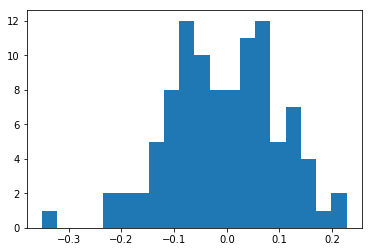

In [4]:
n, sigma = 100, 0.1
x = np.array([gaussianRan(sigma) for x in range(n)])

bins = int(n/5)
plt.hist(x, bins)
plt.show()

In [5]:
def functionx(x, sigma):
    return np.cos(2*np.pi*x) + gaussianRan(sigma)

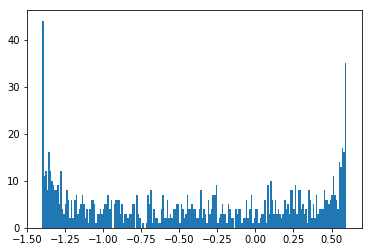

In [6]:
# Test functionx
n, sigma = 50, 1
x = np.random.uniform(low=0, high=1, size=(n,1))
y = functionx(x, sigma)

bins = int(n/5)
plt.hist(y, bins)
plt.show()

In [7]:
def getData(n, sigma, is_numpy=False, preprocess=False):
    x = np.random.uniform(low=0, high=1, size=(n,1))
    y = functionx(x, sigma)
    
    if preprocess:
        x = preprocessing.scale(x)
        y = preprocessing.scale(y)
    
    if is_numpy:
        return x, y
    return Variable(torch.from_numpy(x)), Variable(torch.from_numpy(y))

Graph input and output results.

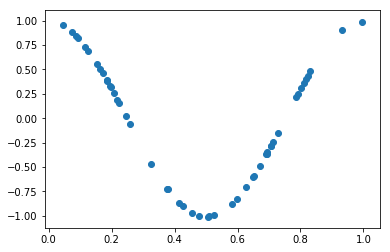

In [31]:
n = 50
sigma = 0.01
x, y = getData(n, sigma, is_numpy=True, preprocess=False)

plt.scatter(x, y)
plt.show()

### Define loss function, polynomial feature function, linear regression model

In [9]:
def forwardTorchNumpy(x, y, w, lambd, is_numpy=False):
    if is_numpy:
        y_pred = np.dot(x,w)
    else:
        y_pred = torch.mm(x,w)
    return getMSE(y_pred, y, w, lambd, is_numpy=is_numpy)

In [67]:
def getMSE(y_pred, y, w, lambd, is_numpy=False):
    if is_numpy:
        return np.mean((y_pred - y)**2) + lambd*np.mean(np.dot(w.T, w))
    return torch.mean((y_pred - y)**2) + lambd*torch.mean(torch.mm(w.t(), w))

In [68]:
# Test getMSE
y_pred = torch.Tensor([[1.5],[1]])
y = torch.Tensor([[2],[2]])
w = torch.Tensor([[1],[1]])
lambd = 1
print(getMSE(y_pred, y, w, lambd))

tensor(2.6250)


In [38]:
def polynomialx(x, d, is_numpy=False):
    if d == 0:
        x = np.zeros_like(x)
    else:
        poly = preprocessing.PolynomialFeatures(d, include_bias=False)
        x = poly.fit_transform(x)
        
    if is_numpy is False:
        x = torch.from_numpy(x)
    return x

In [39]:
# Test polynomialx
x = np.array([[2], [3], [4]])
d = 0
print(polynomialx(x,d))

tensor([[0],
        [0],
        [0]], dtype=torch.int32)


In [44]:
class LrModule(nn.Module):

    def __init__(self, d):
        super(LrModule, self).__init__()
        if d == 0: d = 1
        self.linear = nn.Linear(d,1)

    def forward(self, x):
        # linear
        return self.linear(x)

In [45]:
# Check LrModule
lr = LrModule(0)
print(lr.linear)

Linear(in_features=1, out_features=1, bias=True)


In [16]:
# Test getMSE
x = np.array([[1,2], [1,3], [1,4], [1,5]])
y = np.array([[7], [6], [5], [4]])
w = np.array([[0.1], [0.2]])
y_pred = np.dot(x,w)
res = getMSE(y_pred, y, w, lambd=0, is_numpy=True)
assert res == 23.89

### Gradient Checking

In [17]:
def gradApprox(lr, x, y, lambd, e=1e-2):
    w = lr.linear.weight.data
    w = w.detach().numpy()
    y = y.detach().numpy()
    dwa = np.zeros_like(w)
    
    i = 0
    for val in w[0]:
        wp, wm = w.copy(), w.copy()

        wp[0][i] += e
        wm[0][i] -= e
        
        lr.linear.weight.data = torch.from_numpy(wp)
        y_pred = lr.forward(x)
        y_pred = y_pred.detach().numpy()
        jp = getMSE(y_pred, y, wp, lambd, is_numpy=True)
        
        lr.linear.weight.data = torch.from_numpy(wm)
        y_pred = lr.forward(x)
        y_pred = y_pred.detach().numpy()
        jm = getMSE(y_pred, y, wm, lambd, is_numpy=True)

        dwa[0][i] = (jp - jm)/(2*e)
        i += 1
    
    return dwa

In [18]:
def checkGrad(lr, x, y, lambd):
    dw = lr.linear.weight.grad
    dw = dw.detach().numpy()
    dwa = gradApprox(lr, x, y, lambd)
    print("*****************************************")
    print("dw: ", dw)
    print("dwa:", dwa)
    e = np.linalg.norm(dw-dwa)/(np.linalg.norm(dw) + np.linalg.norm(dwa))
    print("Grad approx error: ", e)
    print("*****************************************")

In [19]:
# Test LrModule gradient
lr = LrModule(3)
x = torch.Tensor([[8,1,6],[3,5,7],[4,9,2]])
y = torch.Tensor([[7],[6],[5]])
w = torch.Tensor([[0.2, 0.3, 0.4]])
b = torch.Tensor([0.1])
lambd = 0
learning_rate=1e-2

lr.linear.weight.data = w
lr.linear.bias.data = b

lr.linear.weight.data = w
lr.linear.bias.data = b
print("w: ", lr.linear.weight.data)
print("b: ", lr.linear.weight.data)
y_pred = lr.forward(x)
cost = getMSE(y_pred, y, w, lambd)
print("Cost: ", cost)
cost.backward()
dw, db = lr.linear.weight.grad, lr.linear.bias.grad
print("dw: ", dw)
print("db: ", db)

# grad checking
checkGrad(lr, x, y, lambd)

# Update gradient
#lr.linear.weight.data -= learning_rate*lr.linear.weight.grad.data
#lr.linear.bias.data -= learning_rate*lr.linear.bias.grad.data

# print("**************")
# print("w: ", lr.linear.weight.data)
# print("b: ", lr.linear.weight.data)
# lr.zero_grad()
# y_pred = lr.forward(x)
# cost = getMSE(y_pred, y, w, lambd)
# print("Cost: ", cost)
# cost.backward()
# dw, db = lr.linear.weight.grad, lr.linear.bias.grad
# print("dw: ", dw)
# print("db: ", db)

w:  tensor([[0.2000, 0.3000, 0.4000]])
b:  tensor([[0.2000, 0.3000, 0.4000]])
Cost:  tensor(2.7067, grad_fn=<ThAddBackward>)
dw:  tensor([[-17.4667,  -8.6667, -15.8667]])
db:  tensor([-2.8000])
*****************************************
dw:  [[-17.46666667  -8.66666667 -15.86666667]]
dwa: [[-17.46666667  -8.66666667 -15.86666667]]
Grad approx error:  2.6439547406212775e-16
*****************************************


### Learned model

In [112]:
def fitData(x, y, d, sigma, lambd=0, learning_rate=1e-1, itera=1000, n_test=1000, check_grad=False):  
    # create polynomial x matrix
    x = polynomialx(x, d)
    
    # keep track of cost for testing
    cost_hist = []
    it_hist = []
    
    lr = LrModule(d)
    
    for i in range(itera):
        # clear grads
        lr.zero_grad()
        
        # Forward
        y_pred = lr.forward(x)
        
        # loss
        w = lr.linear.weight.data
        cost = getMSE(y_pred, y, w, lambd)
        
        # Backward for derivative
        cost.backward()
        
        # Gradient checking
        if check_grad and i>20:
            checkGrad(lr, x, y, lambd)
            break
        
        # Update gradient
        lr.linear.weight.data -= learning_rate*lr.linear.weight.grad.data
        lr.linear.bias.data -= learning_rate*lr.linear.bias.grad.data
        
        # Save cost history for testing
        cost_hist.append(cost.detach().numpy())
        it_hist.append(i)
    
    w = lr.linear.weight.data
    
    # Calculate Ein
    Ein = getMSE(lr.forward(x), y, w, lambd)
    
    # Create test dataset
    x_test, y_test = getData(n_test, sigma)
    
    # Create x_test dimension d
    x_test = polynomialx(x_test, d)
    
    # Calculate Eout
    Eout = getMSE(lr.forward(x_test), y_test, w, lambd)
    
    return Ein.detach().numpy(), Eout.detach().numpy(), lr, [it_hist, cost_hist]

Parameter containing:
tensor([0.5712], requires_grad=True)
[[-0.44799223]]
y_pred and y


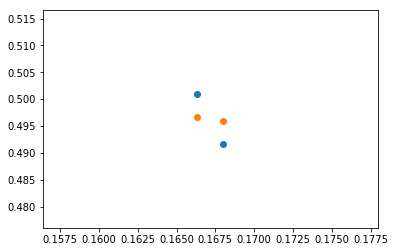

Ein:  1.7837930329171135e-05
Eout:  0.6664503736800094
Loss function vs iterations


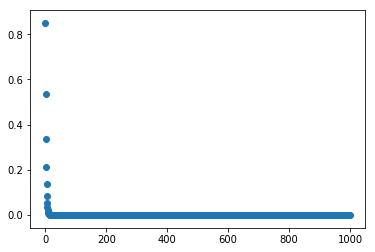

In [137]:
# Test fitData 
d, sigma, n, lambd = 1, 0.01, 2, 0
x, y = getData(n,sigma)
Ein, Eout, lr, plot_data = fitData(x, y, d, sigma, lambd=lambd, check_grad=False)

x_poly = polynomialx(x, d)
y_pred = lr.forward(x_poly)
print(lr.linear.bias)
print(lr.linear.weight.data.detach().numpy().reshape(-1,1))

print("y_pred and y")
plt.scatter(x.detach().numpy(), y.detach().numpy())
plt.scatter(x.detach().numpy(), y_pred.detach().numpy())
plt.show()

print("Ein: ", Ein)
print("Eout: ", Eout)

xx, yy = plot_data
#print(xx)
#print(yy)
print("Loss function vs iterations")
plt.scatter(xx, yy)
plt.show()

### Experiments

In [160]:
def experiment(n, d, sigma, lambd, trials=20, n_test=1000):
    # initialize
    Ein_hist, Eout_hist = np.array([]), np.array([])
    w_hist, b_hist = np.empty([d, 0]), np.array([])
        
    for trail in range(trials):
        x, y = getData(n, sigma)
        Ein, Eout, lr, plot_data = fitData(x, y, d, sigma)
        Ein_hist = np.append(Ein_hist, [Ein])
        Eout_hist = np.append(Eout_hist, [Eout])
        
        if d == 0:
            pass
        else:
            w_hist = np.append(w_hist, lr.linear.weight.data.detach().numpy().reshape(-1,1), axis=1)
            
        b_hist = np.append(b_hist, lr.linear.bias.data.detach().numpy().reshape(-1,1))
    
#     print(Ein_hist)
#     print(Eout_hist)
#     print(w_hist)
#     print(b_hist)
    
    # take the avg
    Ein_avg = np.mean(Ein_hist)
    Eout_avg = np.mean(Eout_hist)
    
    if d == 0:
        pass
    else:
        w_avg = (1/trials)*np.sum(w_hist, axis=1).reshape(1,d)
        
    b_avg = np.mean(b_hist)
    
#     print(Ein_avg)
#     print(Eout_avg)
#     print(w_avg)
#     print(b_avg)
    
    # Create test dataset on averaged polynomials
    x_test, y_test = getData(n_test, sigma)
    
    # Create x_test dimension d
    x_test = polynomialx(x_test, d)
    
    # Ebias
    if d == 0:
        w_avg = torch.from_numpy(np.zeros((1,1)))
    else:
        w_avg = torch.from_numpy(w_avg)
        
    b_avg = torch.Tensor([b_avg])
    lr.linear.weight.data = w_avg
    lr.linear.bias.data = b_avg
    Ebias = getMSE(lr.forward(x_test), y_test, w_avg, lambd)
    Ebias = Ebias.detach().numpy()
    Ebias = float(Ebias)
    
    return Ein_avg, Eout_avg, Ebias

In [161]:
# Test experiment 
d, sigma, n, lambd = 1, 0.01, 5, 0
Ein_avg, Eout_avg, Ebias = experiment(n, d, sigma, lambd)

print("Ein_avg: ", Ein_avg)
print("Eout_avg: ", Eout_avg)
print("Ebias: ", Ebias)

Ein_avg:  0.20804736555975611
Eout_avg:  1.0805796385282038
Ebias:  0.6098438194353933


### Initialize parameters for experiment
The experiment runs through combinations of different sized input, deg of features, and sigmas for f(x). A regularization rate lamba is also set. Lambda is 0 if regularization is not used.

In [162]:
bigN = [2, 5, 10, 20, 50, 100, 200]
deg = list(range(0,21))
#deg = [19]
sigmas = [0.01, 0.1, 1]
#sigmas = [1]
lambd = 0
numCombinations = len(bigN)*len(deg)*len(sigmas)
print(numCombinations)

441


In [163]:
# testing
# bigN = [50]
# deg = [4]
# sigmas = [0.1]

experiments = []

cntCombinations = 0
print("Number combinations: ", numCombinations)

for n in bigN:
    for d in deg:
        for sigma in sigmas:
            cntCombinations+=1
            Ein_avg, Eout_avg, Ebias = experiment(n, d, sigma, lambd)
            
            print("Experiment ", cntCombinations)
            print("Inputs N, d, sigma: %s, %s, %s" % (n, d, sigma))
            print("%s, %s, %s" % (Ein_avg, Eout_avg, Ebias))
            experiments.append([n, d, sigma, Ein_avg, Eout_avg, Ebias])

# save experiment
with open(".\experiments\experiments_8", 'w', encoding="utf-8") as fout:
    pprint(experiments, fout)


Number combinations:  441
Experiment  1
Inputs N, d, sigma: 2, 0, 0.01
0.20202099866399376, 0.7013795408862928, 0.559719289726605
Experiment  2
Inputs N, d, sigma: 2, 0, 0.1
0.24323448736000758, 0.8126194045945578, 0.5044950827359582
Experiment  3
Inputs N, d, sigma: 2, 0, 1
0.21422772215353142, 3.70360098010457, 0.6832181373378134
Experiment  4
Inputs N, d, sigma: 2, 1, 0.01
0.0009204037032872111, 1.9461148745434642, 0.6022332389563443
Experiment  5
Inputs N, d, sigma: 2, 1, 0.1
0.0033297204331698615, 2.0054265632357327, 0.7952537158910008
Experiment  6
Inputs N, d, sigma: 2, 1, 1
0.009048009687831673, 3.6901402499193052, 1.0113130734638134
Experiment  7
Inputs N, d, sigma: 2, 2, 0.01
0.0032554254769771385, 1.6387892836286144, 0.6725325682193629
Experiment  8
Inputs N, d, sigma: 2, 2, 0.1
0.0026616688166338077, 1.6775627176473418, 1.002477890829577
Experiment  9
Inputs N, d, sigma: 2, 2, 1
0.002009650159076173, 3.9528690423565216, 0.5256013964064618
Experiment  10
Inputs N, d, sigma: 

Experiment  78
Inputs N, d, sigma: 5, 4, 1
0.04222917330710011, 3.529049553675784, 1.7658198864994612
Experiment  79
Inputs N, d, sigma: 5, 5, 0.01
0.030294224208769694, 0.7567311806612598, 0.1880618934521185
Experiment  80
Inputs N, d, sigma: 5, 5, 0.1
0.033648778274263866, 1.0886771267930053, 0.19672999226783155
Experiment  81
Inputs N, d, sigma: 5, 5, 1
0.0322391229330383, 2.406320279500849, 1.470455129261775
Experiment  82
Inputs N, d, sigma: 5, 6, 0.01
0.03028454413376831, 0.9331080869779264, 0.22657478863197125
Experiment  83
Inputs N, d, sigma: 5, 6, 0.1
0.039336006252903816, 0.8522522297434388, 0.15042615514956964
Experiment  84
Inputs N, d, sigma: 5, 6, 1
0.043780316196358526, 2.0832664630283046, 1.9166174903424358
Experiment  85
Inputs N, d, sigma: 5, 7, 0.01
0.034611490941213505, 0.7855831445407169, 0.19560826232988898
Experiment  86
Inputs N, d, sigma: 5, 7, 0.1
0.04137407799407942, 1.046669520282326, 0.1464496283485626
Experiment  87
Inputs N, d, sigma: 5, 7, 1
0.025395439

Experiment  155
Inputs N, d, sigma: 10, 9, 0.1
0.059215670189381786, 0.4579445808638707, 0.164880882699655
Experiment  156
Inputs N, d, sigma: 10, 9, 1
0.05136231791564692, 2.4996009641540704, 0.2656198833856934
Experiment  157
Inputs N, d, sigma: 10, 10, 0.01
0.0614298204986047, 0.32433244165538794, 0.14522288600408154
Experiment  158
Inputs N, d, sigma: 10, 10, 0.1
0.05176187043362207, 0.49825212479798325, 0.22326940871035453
Experiment  159
Inputs N, d, sigma: 10, 10, 1
0.06263569569321055, 1.5018604036515542, 0.8982476310193825
Experiment  160
Inputs N, d, sigma: 10, 11, 0.01
0.06259048873737263, 0.27025561640254053, 0.13608660553969454
Experiment  161
Inputs N, d, sigma: 10, 11, 0.1
0.045175648707763846, 0.5770773367334856, 0.2900507973799559
Experiment  162
Inputs N, d, sigma: 10, 11, 1
0.0657669437307063, 2.6149581448945414, 6.243651119110752
Experiment  163
Inputs N, d, sigma: 10, 12, 0.01
0.05795502178099332, 0.41333272094166507, 0.1898118941165681
Experiment  164
Inputs N, d,

Experiment  232
Inputs N, d, sigma: 20, 14, 0.01
0.052828479537687364, 0.2530482192453298, 0.10519796219929167
Experiment  233
Inputs N, d, sigma: 20, 14, 0.1
0.057233370261039265, 0.16106043814936719, 0.09941525547582918
Experiment  234
Inputs N, d, sigma: 20, 14, 1
0.059466062304204384, 1.9995710663683313, 3.282425173816454
Experiment  235
Inputs N, d, sigma: 20, 15, 0.01
0.060125684620227424, 0.22174717607695257, 0.10808570874419286
Experiment  236
Inputs N, d, sigma: 20, 15, 0.1
0.054277093163627964, 0.10570994842119448, 0.07121510004897776
Experiment  237
Inputs N, d, sigma: 20, 15, 1
0.0541003288926041, 4.044453853833346, 0.11401056447467449
Experiment  238
Inputs N, d, sigma: 20, 16, 0.01
0.05308009556224116, 0.25384140803058036, 0.11993631274590599
Experiment  239
Inputs N, d, sigma: 20, 16, 0.1
0.053581964412845004, 0.35235082440971954, 0.11725755901802175
Experiment  240
Inputs N, d, sigma: 20, 16, 1
0.04664962174371988, 2.3167643322986256, 0.1494683458839032
Experiment  241


Experiment  308
Inputs N, d, sigma: 50, 18, 0.1
0.04713411709361079, 0.07429610538711935, 0.05120576825687863
Experiment  309
Inputs N, d, sigma: 50, 18, 1
0.05267200692799347, 1.6611492425612842, 0.07235110565722105
Experiment  310
Inputs N, d, sigma: 50, 19, 0.01
0.05245749512425803, 0.07556353481155928, 0.05515600334993943
Experiment  311
Inputs N, d, sigma: 50, 19, 0.1
0.048089921501097074, 0.0670223179981722, 0.10179722403759849
Experiment  312
Inputs N, d, sigma: 50, 19, 1
0.04911199603266806, 2.021796266374524, 0.32505807514291485
Experiment  313
Inputs N, d, sigma: 50, 20, 0.01
0.04992841576698477, 0.059751430431280714, 0.05327844335267754
Experiment  314
Inputs N, d, sigma: 50, 20, 0.1
0.05004391612489837, 0.06826137206738411, 0.07106441014159234
Experiment  315
Inputs N, d, sigma: 50, 20, 1
0.05395813117121895, 1.1297055355288506, 0.35319857276166144
Experiment  316
Inputs N, d, sigma: 100, 0, 0.01
0.4927505228795181, 0.5064631773455973, 0.5045847089702751
Experiment  317
Inp

Experiment  384
Inputs N, d, sigma: 200, 1, 1
0.4995241410149447, 2.23942813366453, 0.785732284682528
Experiment  385
Inputs N, d, sigma: 200, 2, 0.01
0.191401302076039, 0.19712466451378985, 0.19444478823028086
Experiment  386
Inputs N, d, sigma: 200, 2, 0.1
0.19304025795280982, 0.204898222918268, 0.2032627116222021
Experiment  387
Inputs N, d, sigma: 200, 2, 1
0.19472754949218068, 1.3831036177469855, 1.1134040203369666
Experiment  388
Inputs N, d, sigma: 200, 3, 0.01
0.07582768668606431, 0.07786526902218978, 0.07668335957171303
Experiment  389
Inputs N, d, sigma: 200, 3, 0.1
0.07925220412221183, 0.10823866135220239, 0.07954397062792073
Experiment  390
Inputs N, d, sigma: 200, 3, 1
0.075818709968569, 2.5671152894804807, 0.08009708821711792
Experiment  391
Inputs N, d, sigma: 200, 4, 0.01
0.0709967138848652, 0.07735757727029159, 0.07415668173376853
Experiment  392
Inputs N, d, sigma: 200, 4, 0.1
0.07461883301481011, 0.0897846795282058, 0.08140995422581077
Experiment  393
Inputs N, d, si

### Reports

In [ ]:
def plot_report_graph(x, y_data):
    for entry in data:
        y, label = y_data
        plt.plot(y, label=label)
    plt.show()

In [164]:
# do fun stuff with experiment
with open(".\experiments\experiments_reg_6", "r", encoding='utf-8') as f:
    experiments = eval(f.read())
    
n_dict, d_dict, sigma_dict = dict(), dict(), dict()
for exp in experiments:
    n, d, s = exp[0], exp[1], exp[2]
    
    n_dict[n] = n_dict.get(n, np.array([0, 0, 0])) + np.array(exp[3:6])
    d_dict[d] = d_dict.get(d, np.array([0, 0, 0])) + np.array(exp[3:6])
    sigma_dict[s] = sigma_dict.get(s, np.array([0, 0, 0])) + np.array(exp[3:6])

# avg (this actually isn't needed if I am normalizing from range 0 to 1)
n_dict = {k: x/(numCombinations/len(n_dict)) for k, x in n_dict.items()}
d_dict = {k: x/(numCombinations/len(d_dict)) for k, x in d_dict.items()}
sigma_dict = {k: x/(numCombinations/len(sigma_dict)) for k, x in sigma_dict.items()}

# pprint(n_dict)
# pprint(d_dict)
# pprint(sigma_dict)

# plot n vs Ein_avg, Eout_avg, Ebias
y_Ein = [n_dict[n][0] for n in bigN]
y_Eout = [n_dict[n][1] for n in bigN]
y_Ebias = [n_dict[n][2] for n in bigN]

plot_report_graph(bigN, [[y_Ein, "Ein"], [y_Eout, "Eout"], [y_Ebias, "Ebias"]])
# plt.plot(bigN, y_Ein)
# plt.plot(bigN, y_Eout)
# plt.plot(bigN, y_Ebias)
# plt.show()

# plot deg vs Ein_avg, Eout_avg, Ebias
y_Ein = [d_dict[n][0] for n in deg]
y_Eout = [d_dict[n][1] for n in deg]
y_Ebias = [d_dict[n][2] for n in deg]

plt.plot(deg, y_Ein)
plt.plot(deg, y_Eout)
plt.plot(deg, y_Ebias)
plt.show()

# plot sigma vs Ein_avg, Eout_avg, Ebias
y_Ein = [sigma_dict[n][0] for n in sigmas]
y_Eout = [sigma_dict[n][1] for n in sigmas]
y_Ebias = [sigma_dict[n][2] for n in sigmas]

plt.plot(sigmas, y_Ein)
plt.plot(sigmas, y_Eout)
plt.plot(sigmas, y_Ebias)
plt.show()

NameError: name 'plot_report_graph' is not defined